In [1]:
# Uninstall existing numpy, gensim, and pandas forcefully
!pip uninstall numpy gensim pandas -y

# Reinstall numpy first. Using --no-cache-dir can sometimes help prevent caching issues.
!pip install numpy --upgrade --no-deps --no-cache-dir

# Reinstall gensim. This should now use the newly installed numpy during its setup.
!pip install gensim --upgrade --no-cache-dir

# Reinstall pandas, ensuring it uses the newly installed numpy
!pip install pandas --upgrade --no-cache-dir

# After running these commands, **RESTART YOUR PYTHON KERNEL**
# Then, run your notebook cells from the beginning.

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
Found existing installation: pandas 2.2.3
Uninstalling pandas-2.2.3:
  Successfully uninstalled pandas-2.2.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 177.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 300.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 242.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is 

In [2]:
!pip3 install pyro-ppl

In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.distributions import constraints
import functools

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, JitTraceEnum_ELBO, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList, AutoDelta
from pyro.optim import ClippedAdam

# Download required resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Initialize tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
punctuation = set(string.punctuation)

# Define the preprocessing function
def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation and numbers
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    tokens = [stemmer.stem(word) for word in tokens]  # Stem the words
    return tokens

def add_mask_column(df, column_name, length, new_column_name='masked_list'):
    def pad_and_create_mask(lst):
        # Truncate if list is longer than the specified length
        truncated = lst[:length]

        # Create mask: 1s for actual values, 0s for padding
        mask = [1] * len(truncated)
        padding_length = max(0, length - len(truncated))
        mask += [0] * padding_length

        # Pad list with 0s if shorter than desired length
        padded_lst = truncated + [0] * padding_length

        return padded_lst, mask

    # Apply padding and mask creation
    result = df[column_name].apply(pad_and_create_mask)
    df[column_name] = result.apply(lambda x: x[0])  # overwrite with padded/truncated list
    df[new_column_name] = result.apply(lambda x: x[1])  # add mask column
    return df

In [5]:
# Load the dataset
df = pd.read_csv("tmdb_5000_movies.csv")

# Remove rows with missing values in the 'overview' column
df.dropna(subset=['overview'], inplace=True)

In [6]:
# Apply to the DataFrame
df['processed'] = df['overview'].apply(preprocess_text)

# Create a dictionary and corpus for the processed text
dictionary = Dictionary(df['processed'])

# Map each list of tokens to a list of word indexes
df['overview_indexed'] = df['processed'].apply(lambda tokens: dictionary.doc2idx(tokens))

df['overview_length'] = df['overview_indexed'].apply(len)

df = df[df['overview_length'] >= 20]

# Create a mask column for the dataframe
df = add_mask_column(df, 'overview_indexed', length=60, new_column_name="overview_masked")


<ipython-input-4-d5367321cdd7>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = result.apply(lambda x: x[0])  # overwrite with padded/truncated list
<ipython-input-4-d5367321cdd7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_column_name] = result.apply(lambda x: x[1])  # add mask column


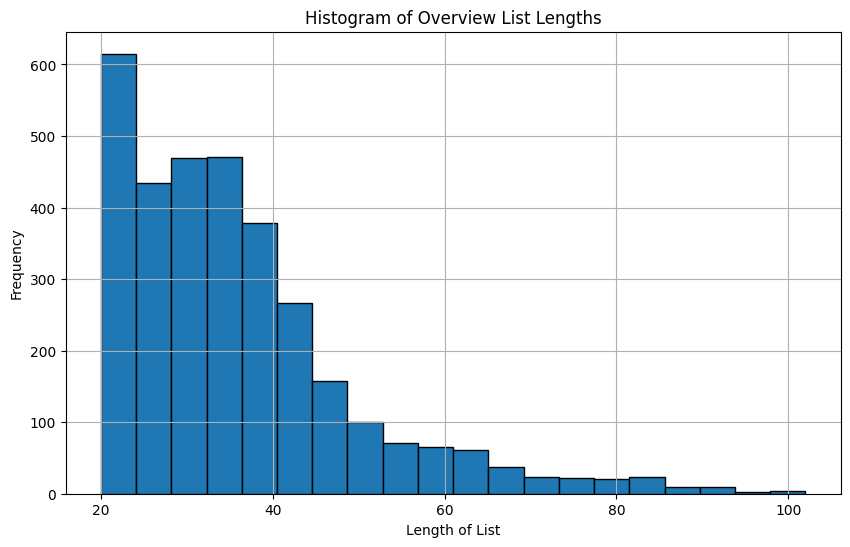

In [7]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['overview_length'], bins=20, edgecolor='black')
plt.title('Histogram of Overview List Lengths')
plt.xlabel('Length of List')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [8]:
W = df["overview_indexed"]
Mask = df["overview_masked"]

# Convert to a LongTensor (2D tensor)
tensor_W = torch.tensor(W.tolist(), dtype=torch.long).T
tensor_Mask = torch.tensor(Mask.tolist(), dtype=torch.bool).T

In [9]:
num_words = len(dictionary)
num_topics = 20
num_docs = 3236
num_words_per_doc = 60

In [10]:
def model(data=None, mask=None, batch_size=None):
    """LDA model with masking for variable-length documents."""
    with pyro.plate("topics", num_topics):
        topic_words = pyro.sample(
            "topic_words", dist.Dirichlet(torch.ones(num_words) / num_words)
        )

    with pyro.plate("documents", num_docs, batch_size) as ind:
        data = data[:, ind]  # data: [max_words, batch_size]
        if mask is not None:
            mask = mask[:, ind]  # same shape as data

        doc_topics = pyro.sample(
            "doc_topics", dist.Dirichlet(torch.ones(num_topics) / num_topics)
        )

        with pyro.plate("words", num_words_per_doc):
            with pyro.poutine.mask(mask=mask):
                word_topics = pyro.sample(
                    "word_topics", dist.Categorical(doc_topics),
                    infer={"enumerate": "parallel"}
                )

                doc_words = pyro.sample(
                    "doc_words",
                    dist.Categorical(topic_words[word_topics]),
                    obs=data
                )

    return topic_words, doc_words

In [ ]:
pyro.clear_param_store()

def my_local_guide(data=None, mask=None, batch_size=None):
    topic_words_posterior = pyro.param(
            "topic_words_posterior",
            lambda: torch.ones(num_topics, num_words),
            constraint=constraints.positive)

    with pyro.plate("topics", num_topics):
        pyro.sample("topic_words", dist.Dirichlet(topic_words_posterior))

    doc_topics_posterior = pyro.param(
            "doc_topics_posterior",
            lambda: torch.ones(num_docs, num_topics),
            constraint=constraints.simplex)

    with pyro.plate("documents", num_docs, batch_size) as ind:
        pyro.sample("doc_topics", dist.Delta(doc_topics_posterior[ind], event_dim=1))

    #beta_means = pyro.param(
    #        "beta_means",
    #        lambda: torch.zeros(num_docs, num_words),

    #beta = pyro.sample("beta", pyro.Normal(beta_means, 1))


guide = AutoGuideList(model)
guide.add(AutoDiagonalNormal(pyro.poutine.block(model, expose=['doc_topics']))) # We add the weights variables here
guide.add(my_local_guide)  # automatically wrapped in an AutoCallable

guide = my_local_guide

elbo = TraceEnum_ELBO(max_plate_nesting=3)

optim = ClippedAdam({'lr': 0.005})
svi = SVI(model, guide, optim, elbo)

# Define the number of optimization steps
n_steps = 2000

# do gradient steps
for step in range(n_steps):
    elbo = svi.step(tensor_W, tensor_Mask, batch_size=64)
    if step % 100 == 0:
        #print('.', end='')
        print("[%d] ELBO: %.1f" % (step, elbo))

In [ ]:
pyro.get_param_store().save("model_params.pyro")